In [2]:
import numpy as np
import readdy

In [3]:
readdy.__version__

'v1.0.1-0'

Step 1: Define the system

In [4]:
system = readdy.ReactionDiffusionSystem(box_size=[150, 150, 150])
system.periodic_boundary_conditions = False, False, False

system.add_species("Ligand", diffusion_constant=3.)
system.add_species("Decay", diffusion_constant=1.)
system.add_topology_species("T", diffusion_constant=1.)
system.add_topology_species("unstable T", diffusion_constant=1.)

Add a decay reaction for "Decay" praticles and harmonic repulsion between "unstable T" and "Decay"

In [5]:
system.reactions.add("decay: Decay ->", .1)
system.potentials.add_box("Ligand", 10., [-70, -70, -70], [130, 130, 130])
system.potentials.add_box("Decay", 10., [-70, -70, -70], [130, 130, 130])
system.potentials.add_box("T", 10., [-70, -70, -70], [130, 130, 130])
system.potentials.add_box("unstable T", 10., [-70, -70, -70], [130, 130, 130])
system.potentials.add_harmonic_repulsion("Decay", "unstable T", force_constant=20., 
                                         interaction_distance=2.)

Add
- harmonic bonds and angles between pairs/triples of "T" and "unstable T"
- three topology types: stable (with no topology reactions), intermediate, and unstable

In [6]:
system.topologies.configure_harmonic_bond("T", "T", force_constant=20., length=2.)
system.topologies.configure_harmonic_bond("unstable T", "unstable T", force_constant=20., 
                                          length=2.)

system.topologies.add_type("stable")
system.topologies.add_type("intermediate")
system.topologies.add_type("unstable")

Change the topology type from stable to intermediate

In [7]:
system.topologies.add_spatial_reaction(
    "encounter: stable(T) + (Ligand) -> intermediate(T) + (Ligand)", 
    rate=10.0, radius=2.0
)

Change the topology type from intermediate to unstable, change particle types from T to unstable T

In [8]:
def intermediate_rate_function(topology):
    return 1e3
def intermediate_reaction_function(topology):
    recipe = readdy.StructuralReactionRecipe(topology)
    for i in range(len(topology.get_graph().get_vertices())):
        recipe.change_particle_type(i, "unstable T")
    recipe.change_topology_type("unstable")
    return recipe
system.topologies.add_structural_reaction(topology_type="intermediate", 
                                          reaction_function=intermediate_reaction_function, 
                                          rate_function=intermediate_rate_function)

Randomly select a vertex and separate it from the graph, change it's particle type to Decay

In [9]:
def unstable_rate_function(topology):
    return .1
def unstable_reaction_function(topology):
    recipe = readdy.StructuralReactionRecipe(topology)
    index = np.random.randint(0, len(topology.particles))
    recipe.separate_vertex(index)
    recipe.change_particle_type(index, "Decay")
    return recipe
system.topologies.add_structural_reaction(topology_type="unstable",
                                          reaction_function=unstable_reaction_function, 
                                          rate_function=unstable_rate_function)

Step 2: Create the simulation object out of the system

In [10]:
simulation = system.simulation(kernel="CPU")

add topology

In [11]:
n_topology_particles = 70
positions = [[0, 0, 0], np.random.normal(size=3)]
for i in range(n_topology_particles-2):
    delta = positions[-1] - positions[-2]
    offset = np.random.normal(size=3) + delta
    offset = offset / np.linalg.norm(offset)
    positions.append(positions[-1] + 2.*offset)
topology = simulation.add_topology(topology_type="stable", particle_types="T", 
                                   positions=np.array(positions))

set up connectivity of topology

In [12]:
graph = topology.get_graph()
for i in range(len(graph.get_vertices())-1):
    graph.add_edge(i, i+1)

add ligands

In [13]:
simulation.add_particles("Ligand",-6 * np.ones((5, 3)))

In [14]:
simulation.output_file = "topology_simulation.h5"
simulation.record_trajectory()

In [15]:
simulation.run(n_steps=10000, timestep=1e-2)

Configured kernel context with:
--------------------------------
 - kBT = 2.43614
 - periodic b.c. = (false, false, false)
 - box size = (150, 150, 150)
 - particle types:
     * Topology particle type "unstable T" with D=1
     * Topology particle type "T" with D=1
     *  particle type "Ligand" with D=3
     *  particle type "Decay" with D=1
 - potentials of order 1:
     * for type "Decay"
         * Box potential with origin=(-70, -70, -70), extent=(130, 130, 130), and force constant k=10
     * for type "Ligand"
         * Box potential with origin=(-70, -70, -70), extent=(130, 130, 130), and force constant k=10
     * for type "unstable T"
         * Box potential with origin=(-70, -70, -70), extent=(130, 130, 130), and force constant k=10
     * for type "T"
         * Box potential with origin=(-70, -70, -70), extent=(130, 130, 130), and force constant k=10
 - potentials of order 2:
     * for types "Decay" and "unstable T"
         * Harmonic repulsion with force constant k=20

In [16]:
traj = readdy.Trajectory(simulation.output_file)

In [17]:
traj.convert_to_xyz()

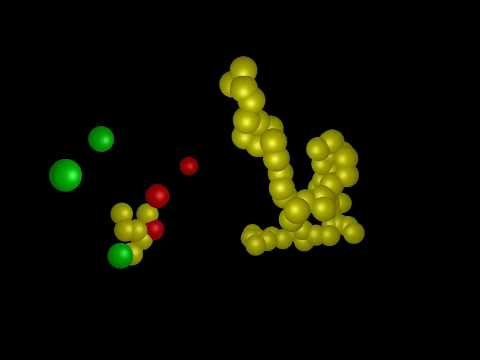

In [18]:
from IPython.display import YouTubeVideo
YouTubeVideo('9cG2J1Nihnk')